In [8]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from Thomas_method import modthomas


def uex(x, bdtype):
    if (bdtype == 'Dirichlet'):
        return (4 * pi ** 2 * (x + 1) + np.cos(2 * pi * x) - 1) / (4 * pi ** 2)
    elif (bdtype == 'Mixed'):
        return (pi ** 2 * (8 * x + 4) + np.cos(2 * pi * x) - 1) / (4 * pi ** 2)


def rhs(x):
    return -np.cos(2 * pi * x)


def setboundaries(M, h, bdtype):
    x = np.linspace(0, 1, M + 1)
    if (bdtype == 'Dirichlet'):
        f = rhs(x[1:M]) #x_1, ..., x_{M-1}
        f[0] = -np.cos(2 * pi * x[1]) - 1 / h ** 2  # first component of f
        f[-1] = -np.cos(2 * pi * x[M - 1]) - 2 / h ** 2 #last component

    elif bdtype == 'Mixed':
        f = rhs(x[1:M + 1])  # x_1,..., x_M
        f[0] = -np.cos(2 * pi * x[1]) - 1 / h ** 2
        f[-1] = -np.cos(2 * pi * x[M]) - 4 / h
    
    return f


def orderplot(mrange, bdtype):
    err = []
    a = 0
    b = 1
    for M in mrange:
        h = 1 / M
        x = np.linspace(a, b, M + 1)
        f = setboundaries(M, h, bdtype)
        if (bdtype == 'Dirichlet'):
            diag = -2 * np.ones(M - 1) / h ** 2
            subd = np.ones(M - 2) / h ** 2
            supr = np.ones(M - 2) / h ** 2
            u = modthomas(diag, subd, supr, f)
            err.append(np.linalg.norm(uex(x[1:M], bdtype) - u, np.Inf))
            plt.figure()
        
        elif (bdtype == 'Mixed'):
            diag = -2 * np.ones(M) / h ** 2
            subd = np.ones(M - 1) / h ** 2
            subd[M - 2] = 2 / h ** 2
            supr = np.ones(M - 1) / h ** 2
            u = modthomas(diag, subd, supr, f)
            err.append(np.linalg.norm(uex(x[1:M + 1], bdtype) - u, np.Inf))
        
    plt.figure(figsize=(8,8))
    plt.loglog(mrange, err, '-o', label='numerical error')
    plt.loglog(mrange, err[-1] * mrange[-1] / mrange, '-', label='ordine 1')
    plt.loglog(mrange, err[-1] * (mrange[-1] / mrange) ** 2, '-', label='order 2')
    plt.title('Order of convergence  for ' + str(bdtype))
    plt.legend()
    plt.show()

Solution of the Poisson equation with $f(x)=\cos(2 \pi x)$ as rhs with inhomogeneous Dirichlet boundary conditions and tridiagonal elimination as fast Poisson solver. 

I discretize with $M+1$ points $x_0, \ldots, X_M$ the interval $[0,1]$. Due to Dirichlet, I do not need to store $u_0$ and $u_M$ and hence I solve just at internal points $x_1, \ldots, X_{M-1}$, by changing the discrete rhs $\vec{f}$.

At $x=x_1$: 
\begin{align}
\frac{-2u_1+u_2}{h^2} = -\cos(2 \pi x_1) - \frac{1}{h^2}
\end{align}

At $x=x_M-1$:  
\begin{align}
\frac{u_{M-2}-2u_{M-1} }{h^2} = - \cos(2 \pi x_{M-1} ) - \frac{2}{h^2}
\end{align}


So $\vec{f}= [f_1,f_2, \ldots, f_{M-1}]$ where 
\begin{align}
f_1=-\cos(2 \pi x_1) - \frac{1}{h^2}
\end{align}
and
\begin{align}
f_{M-1}= - \cos(2 \pi x_{M-1} ) - \frac{2}{h^2}
\end{align}

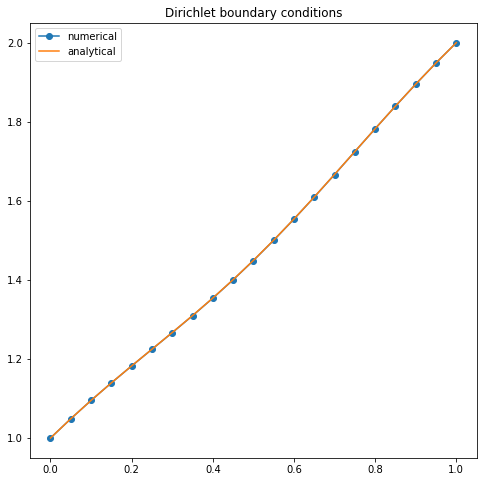

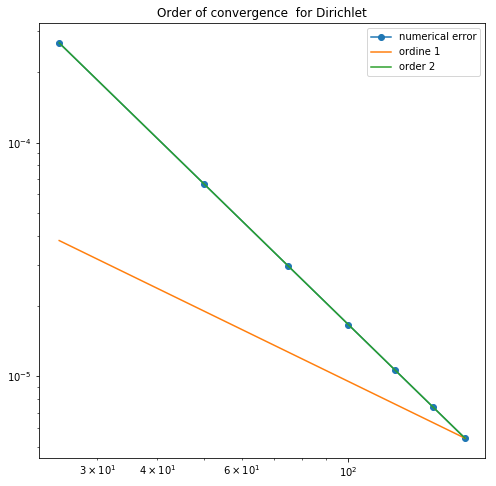

In [9]:
################# Dirichlet Boundary conditions #################
M = 20
x = np.linspace(0, 1, M + 1)
h = 1 / M
f = setboundaries(M, h, 'Dirichlet')
diag = -2 * np.ones(M - 1) / h ** 2
subd = np.ones(M - 2) / h ** 2  # store diagonal to use thomas algorithm
supr = np.ones(M - 2) / h ** 2
u_int = modthomas(diag, subd, supr, f)  # solve at internal points
U = np.zeros(M + 1)
U[0] = 1  # at x=x_0
U[M] = 2  # at x=x_M
U[1:M] = u_int  # from x_1 a to x_{M-1}
plt.figure(figsize=(8,8))
plt.plot(x, U, '-o', label='numerical')
plt.plot(x, uex(x, 'Dirichlet'), '-', label='analytical')
plt.title('Dirichlet boundary conditions')
plt.legend()
plt.show()

# Run error plot
mrange = np.arange(25, 200, 25)
orderplot(mrange, 'Dirichlet')

With Neumann boundary conditions, I use the points $x_1, \ldots, x_M$ since at $x_0$ the value is already determined by Dirichlet boundary conditions.

So $u_0$ is already given, and hence the rhs $\vec{f} = [f_1, \ldots, f_M]$ where

\begin{align}
f_1 = - \cos(2 \pi x) -  \frac{1}{h^2}
\end{align}

as before.

Now the last line reads: $\frac{u_{M+1} -  2u_M + u_{M-1}}{h^2} = - \cos(2 \pi x_M)$

By the Neumann b.c. at $x=x_M=1$ follows $u_{M+1}=4h + u_{M-1}$

and hence the last line reads: 
\begin{align}
\frac{2u_{M-1}-2u_M}{h^2} = - \cos(2 \pi x_M)- \frac{4}{h}
\end{align}


Hence what has to be changed is the last entry of the subdiagonal (with a $2$ instead of $1$) and 
\begin{align}
f_M= - \cos(2 \pi x_M)- \frac{4}{h}
\end{align}

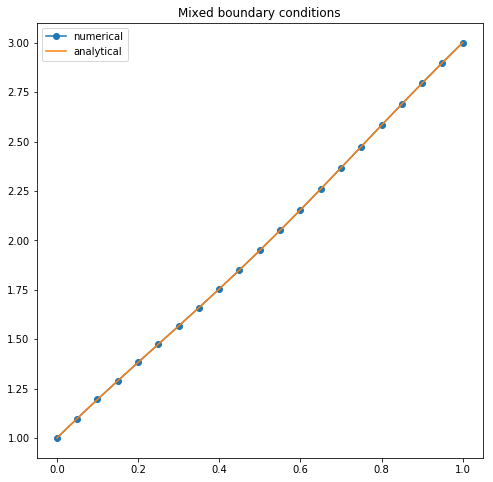

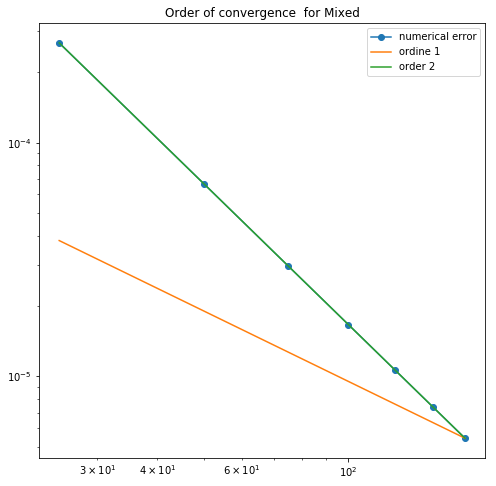

In [12]:
################# Mixed Boundary conditions #################

diag = -2 * np.ones(M) / h ** 2
subd = np.ones(M - 1) / h ** 2
subd[M - 2] = 2 / h ** 2 #to impose Neumann
supr = np.ones(M - 1) / h ** 2

b = setboundaries(M, h, 'Mixed')

u_int = modthomas(diag, subd, supr, b)  # solve at internal points
U = np.zeros(M + 1)
U[0] = 1  # at x=x_0
U[1:M + 1] = u_int  # from x_1 a to x_{M}
plt.figure(figsize=(8,8))
plt.plot(x, U, '-o', label='numerical')
plt.plot(x, uex(x, 'Mixed'), label='analytical')
plt.legend()
plt.title('Mixed boundary conditions')
plt.show()

mrange = np.arange(25, 200, 25)
orderplot(mrange, 'Mixed')